In [318]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tqdm
import random

In [302]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Hyperparameters
batch_size = 4
n_epochs = 20
learning_rate = 0.001

In [273]:
# Make dataset CIFAR10
# Load from by pickle
def unpickle(file):
    with open(file, 'rb') as fo:
        data = pickle.load(fo, encoding='bytes')
    return data


# Dataset class
class Cifar10(torch.utils.data.Dataset):
    
    def __init__(self, train=True, transform=None):
        # Train or test flag
        self.train = train
        if train:
            current_batch = unpickle('data/cifar-10-batches-py/data_batch_1')
            self.x = current_batch[b'data']
            self.y = current_batch[b'labels']
            for index in range(2, 6):
                current_batch = unpickle(f'data/cifar-10-batches-py/data_batch_{index}')
                self.x = np.vstack([self.x, current_batch[b'data']])
                self.y += current_batch[b'labels']
        else:
            self.x = unpickle('data/cifar-10-batches-py/test_batch')[b'data']
            self.y = unpickle('data/cifar-10-batches-py/test_batch')[b'labels']
        self.transform = transform
        self.numpy_x = self.x.reshape(-1, 3, 32, 32).astype(np.int64)
        # Making reshape according to ToTensor() transformer
        self.x = self.x.reshape(-1, 32, 32, 3)
        self.y = np.array(self.y).reshape(-1, 1)
    
    def __getitem__(self, index):
        sample = self.x[index], self.y[index]
        if self.transform:
            images = self.transform(sample[0])
        if self.train:
            return images, torch.LongTensor(sample[1])
        else:
            return (images, torch.LongTensor(sample[1]), self.numpy_x[index])
    
    def __len__(self):
        return self.x.shape[0]

In [274]:
# To transform our images to tensors of normalized range [-1, 1]
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
# Load datasets
train_dataset = Cifar10(train=True, transform=transform)
test_dataset = Cifar10(train=False, transform=transform)
# Make DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
# Classes for classification 
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [287]:
# Plotting fucntion, dstack - through 3 dimension concatination
def plot_picture(image, label):
    image_r = image[0, :, :]
    image_g = image[1, :, :]
    image_b = image[2, :, :]
    image_rgb = np.dstack((image_r, image_g, image_b))
    #image_rgb = np.transpose(image1, (1, 2, 0))
    plt.title(f'Class: {classes[label]} | Shape of pic: {image_rgb.shape}')    
    plt.imshow(image_rgb, interpolation='bicubic')
    plt.show()

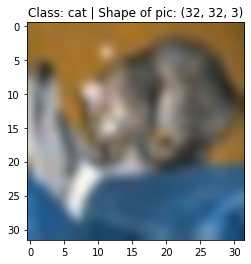

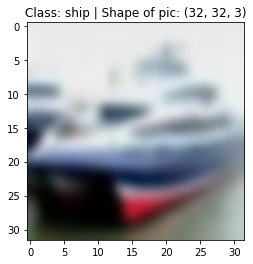

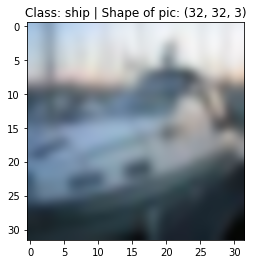

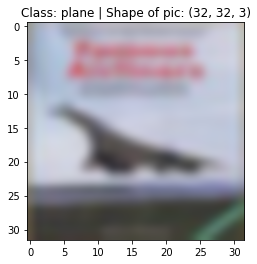

In [301]:
# Draw some pictures with their labels
for pic_idx in range(4): 
    plot_picture(test_dataset[pic_idx][2], test_dataset[pic_idx][1].item());

In [303]:
# Implementation of convolutional neural network
class ConvNet(nn.Module):
    
    def __init__(self):
        super().__init__()
        # First convolutional layer with input channels = 3, output channels = 6, conv. kernel = 5 x 5
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [305]:
# Shapes explanation of conv and pooling layers
dataiter = iter(train_loader)
images, labels = next(dataiter)
conv1 = nn.Conv2d(3, 6, 5)
pool = nn.MaxPool2d(2, 2)
conv2 = nn.Conv2d(6, 16, 5)
print(images.shape)
x = conv1(images)
print(x.shape)
x = pool(x)
print(x.shape)
x = conv2(x)
print(x.shape)
x = pool(x)
print(x.shape)

torch.Size([4, 3, 32, 32])
torch.Size([4, 6, 28, 28])
torch.Size([4, 6, 14, 14])
torch.Size([4, 16, 10, 10])
torch.Size([4, 16, 5, 5])


In [307]:
# Convolutional neural network model
cnn_model = ConvNet().to(device)
# Cross entropy loss
criterion = nn.CrossEntropyLoss()
# Optimizer
optimizer = torch.optim.Adam(cnn_model.parameters(), lr=learning_rate)

In [311]:
# Training loop
n_total_steps = len(train_loader)
for epoch in range(n_epochs):
    # Iteration by 1 mini-batch
    for i, (images, labels) in enumerate(train_loader):
        # Zeroing gradients
        optimizer.zero_grad()
        # Using cuda
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        # Counting loss
        loss = criterion(outputs, labels.flatten())
        # Proccessing gradients
        loss.backward()
        # Correcting weights
        optimizer.step()
        if (i + 1) % 200 == 0:
            print(f'Epoch: {epoch + 1} / {n_epochs}| Step: {i + 1} / {n_total_steps}| Loss: {loss.item():.4f}')

Epoch: 1 / 20| Step: 200 / 12500| Loss: 2.1457
Epoch: 1 / 20| Step: 400 / 12500| Loss: 2.0242
Epoch: 1 / 20| Step: 600 / 12500| Loss: 1.9061
Epoch: 1 / 20| Step: 800 / 12500| Loss: 2.5357
Epoch: 1 / 20| Step: 1000 / 12500| Loss: 1.6755
Epoch: 1 / 20| Step: 1200 / 12500| Loss: 1.2932
Epoch: 1 / 20| Step: 1400 / 12500| Loss: 2.1245
Epoch: 1 / 20| Step: 1600 / 12500| Loss: 1.6202
Epoch: 1 / 20| Step: 1800 / 12500| Loss: 1.0421
Epoch: 1 / 20| Step: 2000 / 12500| Loss: 1.6161
Epoch: 1 / 20| Step: 2200 / 12500| Loss: 1.2396
Epoch: 1 / 20| Step: 2400 / 12500| Loss: 1.9239
Epoch: 1 / 20| Step: 2600 / 12500| Loss: 1.1400
Epoch: 1 / 20| Step: 2800 / 12500| Loss: 1.7876
Epoch: 1 / 20| Step: 3000 / 12500| Loss: 1.1688
Epoch: 1 / 20| Step: 3200 / 12500| Loss: 1.4049
Epoch: 1 / 20| Step: 3400 / 12500| Loss: 1.7119
Epoch: 1 / 20| Step: 3600 / 12500| Loss: 2.0387
Epoch: 1 / 20| Step: 3800 / 12500| Loss: 1.8649
Epoch: 1 / 20| Step: 4000 / 12500| Loss: 3.2015
Epoch: 1 / 20| Step: 4200 / 12500| Loss: 0.5

Epoch: 3 / 20| Step: 9600 / 12500| Loss: 1.1302
Epoch: 3 / 20| Step: 9800 / 12500| Loss: 0.8672
Epoch: 3 / 20| Step: 10000 / 12500| Loss: 2.2682
Epoch: 3 / 20| Step: 10200 / 12500| Loss: 1.2554
Epoch: 3 / 20| Step: 10400 / 12500| Loss: 0.9043
Epoch: 3 / 20| Step: 10600 / 12500| Loss: 1.6370
Epoch: 3 / 20| Step: 10800 / 12500| Loss: 2.0505
Epoch: 3 / 20| Step: 11000 / 12500| Loss: 0.1601
Epoch: 3 / 20| Step: 11200 / 12500| Loss: 1.5920
Epoch: 3 / 20| Step: 11400 / 12500| Loss: 0.9756
Epoch: 3 / 20| Step: 11600 / 12500| Loss: 0.7247
Epoch: 3 / 20| Step: 11800 / 12500| Loss: 1.5452
Epoch: 3 / 20| Step: 12000 / 12500| Loss: 1.7569
Epoch: 3 / 20| Step: 12200 / 12500| Loss: 0.6055
Epoch: 3 / 20| Step: 12400 / 12500| Loss: 0.3681
Epoch: 4 / 20| Step: 200 / 12500| Loss: 1.2300
Epoch: 4 / 20| Step: 400 / 12500| Loss: 1.7217
Epoch: 4 / 20| Step: 600 / 12500| Loss: 0.8059
Epoch: 4 / 20| Step: 800 / 12500| Loss: 1.1435
Epoch: 4 / 20| Step: 1000 / 12500| Loss: 1.8920
Epoch: 4 / 20| Step: 1200 / 125

Epoch: 6 / 20| Step: 6600 / 12500| Loss: 1.1506
Epoch: 6 / 20| Step: 6800 / 12500| Loss: 0.9852
Epoch: 6 / 20| Step: 7000 / 12500| Loss: 2.1793
Epoch: 6 / 20| Step: 7200 / 12500| Loss: 0.9405
Epoch: 6 / 20| Step: 7400 / 12500| Loss: 1.6643
Epoch: 6 / 20| Step: 7600 / 12500| Loss: 0.9087
Epoch: 6 / 20| Step: 7800 / 12500| Loss: 1.4946
Epoch: 6 / 20| Step: 8000 / 12500| Loss: 0.6945
Epoch: 6 / 20| Step: 8200 / 12500| Loss: 0.8376
Epoch: 6 / 20| Step: 8400 / 12500| Loss: 0.7664
Epoch: 6 / 20| Step: 8600 / 12500| Loss: 2.9518
Epoch: 6 / 20| Step: 8800 / 12500| Loss: 1.5577
Epoch: 6 / 20| Step: 9000 / 12500| Loss: 1.1270
Epoch: 6 / 20| Step: 9200 / 12500| Loss: 1.9485
Epoch: 6 / 20| Step: 9400 / 12500| Loss: 2.1732
Epoch: 6 / 20| Step: 9600 / 12500| Loss: 1.9680
Epoch: 6 / 20| Step: 9800 / 12500| Loss: 1.6349
Epoch: 6 / 20| Step: 10000 / 12500| Loss: 1.0566
Epoch: 6 / 20| Step: 10200 / 12500| Loss: 1.6158
Epoch: 6 / 20| Step: 10400 / 12500| Loss: 1.6783
Epoch: 6 / 20| Step: 10600 / 12500| L

Epoch: 9 / 20| Step: 3600 / 12500| Loss: 0.4207
Epoch: 9 / 20| Step: 3800 / 12500| Loss: 0.9977
Epoch: 9 / 20| Step: 4000 / 12500| Loss: 1.7633
Epoch: 9 / 20| Step: 4200 / 12500| Loss: 0.5693
Epoch: 9 / 20| Step: 4400 / 12500| Loss: 0.6781
Epoch: 9 / 20| Step: 4600 / 12500| Loss: 0.9709
Epoch: 9 / 20| Step: 4800 / 12500| Loss: 0.6416
Epoch: 9 / 20| Step: 5000 / 12500| Loss: 1.3392
Epoch: 9 / 20| Step: 5200 / 12500| Loss: 2.0852
Epoch: 9 / 20| Step: 5400 / 12500| Loss: 1.1952
Epoch: 9 / 20| Step: 5600 / 12500| Loss: 1.2525
Epoch: 9 / 20| Step: 5800 / 12500| Loss: 0.8297
Epoch: 9 / 20| Step: 6000 / 12500| Loss: 1.7242
Epoch: 9 / 20| Step: 6200 / 12500| Loss: 0.9895
Epoch: 9 / 20| Step: 6400 / 12500| Loss: 0.9338
Epoch: 9 / 20| Step: 6600 / 12500| Loss: 2.3890
Epoch: 9 / 20| Step: 6800 / 12500| Loss: 1.1556
Epoch: 9 / 20| Step: 7000 / 12500| Loss: 1.4172
Epoch: 9 / 20| Step: 7200 / 12500| Loss: 1.7839
Epoch: 9 / 20| Step: 7400 / 12500| Loss: 1.0006
Epoch: 9 / 20| Step: 7600 / 12500| Loss:

Epoch: 11 / 20| Step: 12400 / 12500| Loss: 0.9925
Epoch: 12 / 20| Step: 200 / 12500| Loss: 1.6972
Epoch: 12 / 20| Step: 400 / 12500| Loss: 0.5824
Epoch: 12 / 20| Step: 600 / 12500| Loss: 0.7198
Epoch: 12 / 20| Step: 800 / 12500| Loss: 0.7908
Epoch: 12 / 20| Step: 1000 / 12500| Loss: 0.3525
Epoch: 12 / 20| Step: 1200 / 12500| Loss: 1.4467
Epoch: 12 / 20| Step: 1400 / 12500| Loss: 0.3891
Epoch: 12 / 20| Step: 1600 / 12500| Loss: 1.0122
Epoch: 12 / 20| Step: 1800 / 12500| Loss: 1.9500
Epoch: 12 / 20| Step: 2000 / 12500| Loss: 0.5893
Epoch: 12 / 20| Step: 2200 / 12500| Loss: 2.1680
Epoch: 12 / 20| Step: 2400 / 12500| Loss: 0.9373
Epoch: 12 / 20| Step: 2600 / 12500| Loss: 1.0866
Epoch: 12 / 20| Step: 2800 / 12500| Loss: 1.6728
Epoch: 12 / 20| Step: 3000 / 12500| Loss: 0.7660
Epoch: 12 / 20| Step: 3200 / 12500| Loss: 1.3744
Epoch: 12 / 20| Step: 3400 / 12500| Loss: 0.5052
Epoch: 12 / 20| Step: 3600 / 12500| Loss: 2.4378
Epoch: 12 / 20| Step: 3800 / 12500| Loss: 0.5247
Epoch: 12 / 20| Step: 4

Epoch: 14 / 20| Step: 8600 / 12500| Loss: 1.3862
Epoch: 14 / 20| Step: 8800 / 12500| Loss: 0.8907
Epoch: 14 / 20| Step: 9000 / 12500| Loss: 1.8907
Epoch: 14 / 20| Step: 9200 / 12500| Loss: 1.0855
Epoch: 14 / 20| Step: 9400 / 12500| Loss: 0.7832
Epoch: 14 / 20| Step: 9600 / 12500| Loss: 1.7276
Epoch: 14 / 20| Step: 9800 / 12500| Loss: 2.3435
Epoch: 14 / 20| Step: 10000 / 12500| Loss: 0.3172
Epoch: 14 / 20| Step: 10200 / 12500| Loss: 0.8137
Epoch: 14 / 20| Step: 10400 / 12500| Loss: 1.0680
Epoch: 14 / 20| Step: 10600 / 12500| Loss: 0.5577
Epoch: 14 / 20| Step: 10800 / 12500| Loss: 0.4636
Epoch: 14 / 20| Step: 11000 / 12500| Loss: 1.6449
Epoch: 14 / 20| Step: 11200 / 12500| Loss: 1.8484
Epoch: 14 / 20| Step: 11400 / 12500| Loss: 0.9458
Epoch: 14 / 20| Step: 11600 / 12500| Loss: 1.3060
Epoch: 14 / 20| Step: 11800 / 12500| Loss: 1.0231
Epoch: 14 / 20| Step: 12000 / 12500| Loss: 0.5867
Epoch: 14 / 20| Step: 12200 / 12500| Loss: 1.0119
Epoch: 14 / 20| Step: 12400 / 12500| Loss: 2.0551
Epoch: 

Epoch: 17 / 20| Step: 4800 / 12500| Loss: 0.6803
Epoch: 17 / 20| Step: 5000 / 12500| Loss: 1.8336
Epoch: 17 / 20| Step: 5200 / 12500| Loss: 1.4723
Epoch: 17 / 20| Step: 5400 / 12500| Loss: 1.2111
Epoch: 17 / 20| Step: 5600 / 12500| Loss: 0.3205
Epoch: 17 / 20| Step: 5800 / 12500| Loss: 0.7677
Epoch: 17 / 20| Step: 6000 / 12500| Loss: 0.7345
Epoch: 17 / 20| Step: 6200 / 12500| Loss: 0.3513
Epoch: 17 / 20| Step: 6400 / 12500| Loss: 0.5541
Epoch: 17 / 20| Step: 6600 / 12500| Loss: 2.0690
Epoch: 17 / 20| Step: 6800 / 12500| Loss: 1.2829
Epoch: 17 / 20| Step: 7000 / 12500| Loss: 0.9162
Epoch: 17 / 20| Step: 7200 / 12500| Loss: 1.4433
Epoch: 17 / 20| Step: 7400 / 12500| Loss: 0.7528
Epoch: 17 / 20| Step: 7600 / 12500| Loss: 0.9833
Epoch: 17 / 20| Step: 7800 / 12500| Loss: 1.1655
Epoch: 17 / 20| Step: 8000 / 12500| Loss: 1.9467
Epoch: 17 / 20| Step: 8200 / 12500| Loss: 1.8510
Epoch: 17 / 20| Step: 8400 / 12500| Loss: 0.5222
Epoch: 17 / 20| Step: 8600 / 12500| Loss: 0.0977
Epoch: 17 / 20| Step

Epoch: 20 / 20| Step: 1000 / 12500| Loss: 1.0653
Epoch: 20 / 20| Step: 1200 / 12500| Loss: 0.7089
Epoch: 20 / 20| Step: 1400 / 12500| Loss: 1.0257
Epoch: 20 / 20| Step: 1600 / 12500| Loss: 1.8466
Epoch: 20 / 20| Step: 1800 / 12500| Loss: 1.0041
Epoch: 20 / 20| Step: 2000 / 12500| Loss: 1.2491
Epoch: 20 / 20| Step: 2200 / 12500| Loss: 0.4274
Epoch: 20 / 20| Step: 2400 / 12500| Loss: 2.4229
Epoch: 20 / 20| Step: 2600 / 12500| Loss: 1.2763
Epoch: 20 / 20| Step: 2800 / 12500| Loss: 0.7224
Epoch: 20 / 20| Step: 3000 / 12500| Loss: 1.4855
Epoch: 20 / 20| Step: 3200 / 12500| Loss: 1.3165
Epoch: 20 / 20| Step: 3400 / 12500| Loss: 0.6838
Epoch: 20 / 20| Step: 3600 / 12500| Loss: 1.1163
Epoch: 20 / 20| Step: 3800 / 12500| Loss: 1.0759
Epoch: 20 / 20| Step: 4000 / 12500| Loss: 1.7001
Epoch: 20 / 20| Step: 4200 / 12500| Loss: 1.1722
Epoch: 20 / 20| Step: 4400 / 12500| Loss: 0.7935
Epoch: 20 / 20| Step: 4600 / 12500| Loss: 0.8850
Epoch: 20 / 20| Step: 4800 / 12500| Loss: 1.5226
Epoch: 20 / 20| Step

In [325]:
# Evaluation 
# Figure out the accuracy and the accuracy for each class
with torch.no_grad():
    n_correct = 0
    n_samples = 0
    # Making lists of size 10 to figure out accuracy for each class in the future
    n_class_correct = [0 for _ in range(10)]
    n_class_samples = [0 for _ in range(10)]
    # Iteration by 1 test mini-batch
    for images, labels, np_images in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = cnn_model(images)
        # Max probability = value predicted by model
        _, predicted = torch.max(outputs, 1)
        n_samples += images.shape[0]
        n_correct += (predicted == labels.flatten()).sum().item()
        for i in range(batch_size):
            label = labels[i]
            pred = predicted[i]
            if label == pred:
                n_class_correct[label] += 1
            n_class_samples[label] += 1
    print(f'Overall Accuracy: {(n_correct / n_samples) * 100}%')
    for i in range(10):
        acc = 100 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy for {classes[i]} = {acc}%')

Overall Accuracy: 53.49%
Accuracy for plane = 59.0%
Accuracy for car = 65.1%
Accuracy for bird = 34.5%
Accuracy for cat = 22.3%
Accuracy for deer = 36.1%
Accuracy for dog = 59.3%
Accuracy for frog = 69.9%
Accuracy for horse = 61.9%
Accuracy for ship = 68.4%
Accuracy for truck = 58.4%


In [363]:
def make_batch_prediction(image_tensor, label, np_image):
    with torch.no_grad():
        image_tensor = image_tensor.to(device)
        label = label.to(device)
        prediction = cnn_model(image_tensor)
        _, predicted_class = torch.max(prediction, dim=1)
        for image_idx in range(len(np_image)):
            plot_picture(np_image[image_idx].numpy(), predicted_class[image_idx].item())

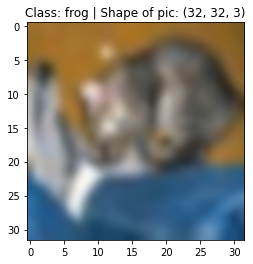

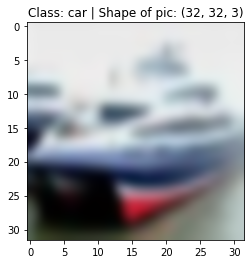

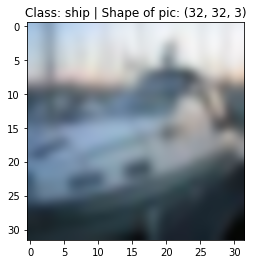

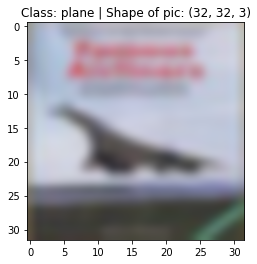

In [364]:
random_set_of_data = next(iter(test_loader))
make_batch_prediction(random_set_of_data[0], random_set_of_data[1], random_set_of_data[2])